# OD Analysis for the Original Network

Using the network data created using [create_tokyo_network.ipynb](create_tokyo_network.ipynb), run an analysis for the original network.



In [1]:
# import libraries
import os
import pandas as pd
import geopandas as gpd
import shapely
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import osmnx as ox

from spatial_interaction_tools import *

## OD Data Manipulation

Use the data from the OD survey and clean it.

In [2]:
# set crs
crs = 'EPSG:6677'

# import data
pt_data = os.path.join('data', 'pt_survey', 'd-1.csv')
od_matrix = pd.read_csv(pt_data, skiprows = 2, header = [0, 1, 2], encoding = 'shift-jis')

# fix column names
od_matrix.columns = list(od_matrix.columns.get_level_values(2)[:3]) + list(od_matrix.columns.get_level_values(1)[3:])

# select columns
areas = ['発地域名', '着地域名']

for a in areas:
    # filter out columns that are not zones
    od_matrix = od_matrix[~od_matrix[a].str.contains('[^:\d\s]', regex = True)]

    # turn the ids into int
    od_matrix[a] = od_matrix[a].str.replace(':', '').astype(int)

# extract only the totals and drop this column
od_matrix = od_matrix[od_matrix['目的種類'] == '計']
od_matrix.drop(columns = '目的種類', inplace = True)

# translate the columns into English
column_en = ['source', 'target', 'rail', 'bus', 'car', 'motorbike', 'bicycle', 'pedestrian', 'other', 'unknown', 'total']
od_matrix.columns = column_en

# change the columns into int
int_columns = ['rail', 'bus', 'car', 'motorbike', 'bicycle', 'pedestrian', 'other', 'unknown', 'total']
for c in int_columns:
    od_matrix[c] = od_matrix[c].str.replace(',', '').astype(int)

# extract the Tokyo Metropolitan Area
od_matrix_tokyo = od_matrix[(od_matrix['source'] < 700) & (od_matrix['target'] < 700)].copy()


## Zones data

Load the zones data.

In [3]:
# load the area data
zones = gpd.read_file(os.path.join('data', 'H30_gis', 'H30_kzone.shp'))

# extract the Tokyo Metropolitan Area
zones_tokyo = zones[zones['kzone'] < 700]

# create zone list
zones_dict = []
for idx, area in zones_tokyo.iterrows():
    node_id = 'zone_' + str(area['kzone'])
    c = area['geometry'].centroid
    y = c.y
    x = c.x
    zones_dict.append((node_id, {
        'y': y,
        'x': x,
        'zone_int': area['kzone'],
        'zone_name': node_id
    }))

## Load Network Data

Load the network data created in the other notebook.

### Street Data for Driving

In [4]:
# load the street network
tokyo_drive_network = ox.load_graphml(os.path.join('data', 'tokyo', 'drive_network_updated.graphml'))

# get the strongly connected network
tokyo_drive_network = ox.truncate.largest_component(tokyo_drive_network, strongly = True)

In [5]:
# fix the data type

for u, v, k, d in tokyo_drive_network.edges(data = True, keys = True):
    # convert wkt to geometry
    if 'geometry' in d.keys() and isinstance(d['geometry'], str):
        d['geometry'] = shapely.wkt.loads(d['geometry'])
    # convert to numeric
    for c in ['speed_kph', 'travel_time', 'travel_time_mins', 'speed_kph_calib', 'travel_time_calib', 'travel_time_mins_calib']:
        d[c] = float(d[c])  

for n, d in tokyo_drive_network.nodes(data = True):
    # convert wkt to geometry
    if 'geometry' in d.keys() and isinstance(d['geometry'], str):
        d['geometry'] = shapely.wkt.loads(d['geometry'])

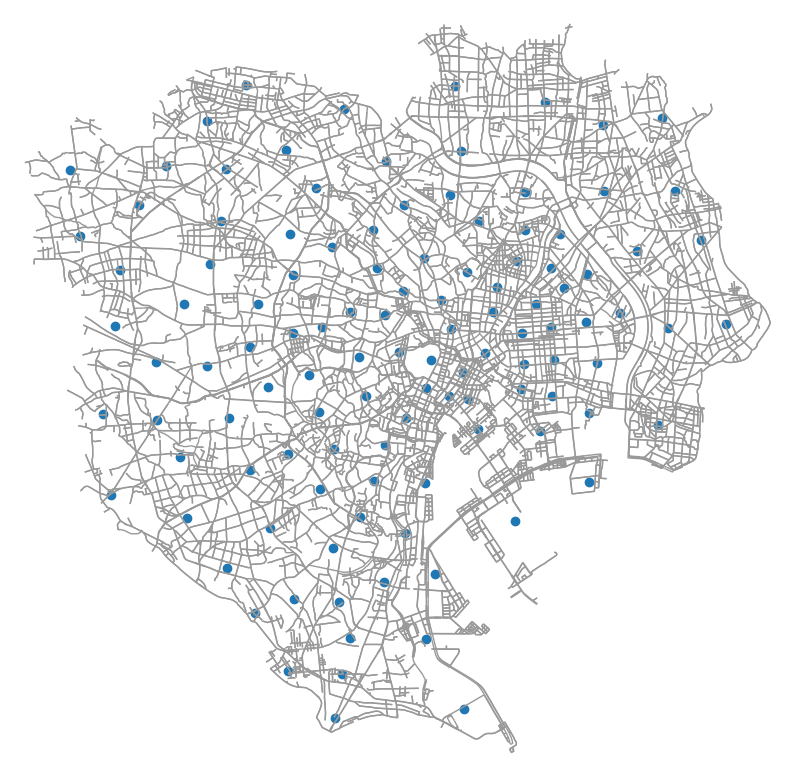

In [6]:
fig, ax = plt.subplots(1, 1, figsize = (10, 10))

zones_tokyo.centroid.plot(ax = ax)
ox.plot_graph(tokyo_drive_network, node_size = 0, show = False, ax = ax)

plt.savefig('slides/img/zone_network.png', bbox_inches = 'tight')

In [7]:
# add the zones to the network
# the centroid of the zones will be connected to the network to the nearest node
edge_dict = []
for z in zones_dict:
    id = z[0]
    data = z[1]
    nearest_node = ox.nearest_nodes(tokyo_drive_network, data['x'], data['y'], return_dist = True)
    data_dict = {
        'length': nearest_node[1],
        'travel_time_mins': 0.1,
        'travel_time_mins_calib': 0.1,        
        'type': 'connection'
    }
    edge_dict.append((id, nearest_node[0], data_dict))
    edge_dict.append((nearest_node[0], id, data_dict))
    
tokyo_drive_network.add_nodes_from(zones_dict)
tokyo_drive_network.add_edges_from(edge_dict)

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0]

### Multilayer network data

In [8]:
# load the street network
tokyo_multimodal_network = nx.read_graphml(os.path.join('data', 'tokyo', 'multimodal_network_updated_weight.graphml'))

#### Bus only and train only layers

Remove bus for rail only, remove rail for bus only.

In [9]:
# create selected networks
bus_network = nx.subgraph(tokyo_multimodal_network, [n for n in tokyo_multimodal_network.nodes() if ('rail' not in n)])
rail_network = nx.subgraph(tokyo_multimodal_network, [n for n in tokyo_multimodal_network.nodes() if ('bus' not in n)])

In [10]:
# truncate
bus_network = ox.truncate.largest_component(bus_network, strongly = True)
rail_network = ox.truncate.largest_component(rail_network, strongly = True)

In [11]:
# create pedestrian network
ped_network = nx.subgraph(tokyo_multimodal_network, [n for n in tokyo_multimodal_network.nodes() if ('rail' not in n) and ('bus' not in n)])
ped_network = ox.truncate.largest_component(ped_network, strongly = True)

## Run the analysis

Using the network data, calculate the shortest distance within the matrix.

In [12]:
# get the zones
zone_nodes = ['zone_' + str(zone) for zone in od_matrix_tokyo['source'].unique()]

In [13]:
drive_time_dict = {}
drive_path_dict = {}
for u in zone_nodes:
    drive_time, path = nx.single_source_dijkstra(
        tokyo_drive_network,
        source = u,
        weight = 'travel_time_mins'
    )
    for v, dist in drive_time.items():
        if 'zone' in str(v):
            drive_time_dict[(u, v)] = dist
    for v, p in path.items():
        if 'zone' in str(v): 
            drive_path_dict[(u, v)] = p

In [14]:
drive_time_dict_calib = {}
drive_path_dict_calib = {}
for u in zone_nodes:
    drive_time, path = nx.single_source_dijkstra(
        tokyo_drive_network,
        source = u,
        weight = 'travel_time_mins_calib'
    )
    for v, dist in drive_time.items():
        if 'zone' in str(v):
            drive_time_dict_calib[(u, v)] = dist
    for v, p in path.items():
        if 'zone' in str(v): 
            drive_path_dict_calib[(u, v)] = p

In [15]:
multimodal_distance_dict = {}
multimodal_path_dict = {}
for u in zone_nodes:
    distance, path = nx.single_source_dijkstra(
        tokyo_multimodal_network, 
        source = u,
        weight='time'
    )
    for v, dist in distance.items():
        if 'zone' in v: 
            multimodal_distance_dict[(u, v)] = dist
    for v, p in path.items():
        if 'zone' in v: 
            multimodal_path_dict[(u, v)] = p

In [ ]:
bus_distance_dict = {}
bus_path_dict = {}
for u in zone_nodes:
    distance, path = nx.single_source_dijkstra(
        bus_network, 
        source = u,
        weight='time'
    )
    for v, dist in distance.items():
        if 'zone' in v: 
            bus_distance_dict[(u, v)] = dist
    for v, p in path.items():
        if 'zone' in v: 
            bus_path_dict[(u, v)] = p

In [ ]:
rail_distance_dict = {}
rail_path_dict = {}
for u in zone_nodes:
    distance, path = nx.single_source_dijkstra(
        rail_network, 
        source = u,
        weight='time'
    )
    for v, dist in distance.items():
        if 'zone' in v: 
            rail_distance_dict[(u, v)] = dist
    for v, p in path.items():
        if 'zone' in v: 
            rail_path_dict[(u, v)] = p

In [ ]:
ped_distance_dict = {}
ped_path_dict = {}
for u in zone_nodes:
    distance, path = nx.single_source_dijkstra(
        ped_network, 
        source = u,
        weight='time'
    )
    for v, dist in distance.items():
        if 'zone' in v: 
            ped_distance_dict[(u, v)] = dist
    for v, p in path.items():
        if 'zone' in v: 
            ped_path_dict[(u, v)] = p

In [ ]:
# change the above dicts into data frame

# initialise dict
distance_dict = {
    'source': [],
    'target': [],
    'drive_time': [],
    'drive_path': [],
    'drive_time_calib': [],
    'drive_path_calib': [],
    'multilayer_time': [],
    'multilayer_path': [],
    'bus_time': [],
    'bus_path': [],
    'rail_time': [],
    'rail_path': [],
    'ped_time': [],
    'ped_path': [],
}

for u in zone_nodes:
    for v in zone_nodes:
        distance_dict['source'].append(u)
        distance_dict['target'].append(v)
        distance_dict['drive_time'].append(drive_time_dict[(u, v)])
        distance_dict['drive_path_calib'].append(drive_path_dict_calib[(u, v)]) 
        distance_dict['drive_time_calib'].append(drive_time_dict_calib[(u, v)])
        distance_dict['drive_path'].append(drive_path_dict[(u, v)])
        distance_dict['multilayer_time'].append(multimodal_distance_dict[(u, v)])
        distance_dict['multilayer_path'].append(multimodal_path_dict[(u, v)])
        distance_dict['bus_time'].append(bus_distance_dict[(u, v)])
        distance_dict['bus_path'].append(bus_path_dict[(u, v)])
        distance_dict['rail_time'].append(rail_distance_dict[(u, v)])
        distance_dict['rail_path'].append(rail_path_dict[(u, v)])
        distance_dict['ped_time'].append(ped_distance_dict[(u, v)])
        distance_dict['ped_path'].append(ped_path_dict[(u, v)])

# save as df
distance_df = pd.DataFrame(distance_dict)


In [ ]:
# get rid of 'zone_' from source and target
for c in ['source', 'target']:
    distance_df[c] = distance_df[c].str.replace('zone_', '').astype(int)

In [ ]:
od_matrix_merged = distance_df.merge(
    od_matrix_tokyo,
    on = ['source', 'target'],
    how = 'left'
).fillna(0)

In [ ]:
od_matrix_merged

,source,target,drive_time,drive_path,drive_time_calib,drive_path_calib,multilayer_time,multilayer_path,bus_time,bus_path,...,ped_path,rail,bus,car,motorbike,bicycle,pedestrian,other,unknown,total
0,10,10,0.000000,[zone_10],0.000000,[zone_10],0.000000,[zone_10],0.000000,[zone_10],...,[zone_10],2325.0,0.0,1304.0,0.0,739.0,25232.0,0.0,853.0,30453.0
1,10,11,3.905000,"[zone_10, 1588249099, 6483620518, 1588249091, ...",7.985534,"[zone_10, 1588249099, 6483620518, 1588249091, ...",25.415646,"[zone_10, street_1866774276, street_558686762,...",25.415646,"[zone_10, street_1866774276, street_558686762,...",...,"[zone_10, street_1866774276, street_558686762,...",3321.0,0.0,1283.0,0.0,144.0,449.0,0.0,79.0,5276.0
2,10,12,2.638333,"[zone_10, 1588249099, 236104886, 1072641884, 5...",5.323813,"[zone_10, 1588249099, 236104886, 1072641884, 5...",24.518493,"[zone_10, street_1866774276, street_558689164,...",25.910477,"[zone_10, street_1866774276, street_558689164,...",...,"[zone_10, street_1866774276, street_558689164,...",4026.0,0.0,1878.0,0.0,460.0,4703.0,0.0,0.0,11067.0
3,10,13,1.803333,"[zone_10, 1588249099, 6483620518, 1588249091, ...",3.569179,"[zone_10, 1588249099, 6483620518, 1588249091, ...",20.986065,"[zone_10, street_1866774276, street_558689164,...",20.986065,"[zone_10, street_1866774276, street_558689164,...",...,"[zone_10, street_1866774276, street_558689164,...",2894.0,0.0,1110.0,0.0,233.0,2375.0,0.0,0.0,6612.0
4,10,20,3.503333,"[zone_10, 1588249099, 6483620518, 257718001, 7...",7.141488,"[zone_10, 1588249099, 6483620518, 257718001, 7...",32.875049,"[zone_10, street_1866774276, street_558689164,...",35.320580,"[zone_10, street_1866774276, street_558689164,...",...,"[zone_10, street_1866774276, street_558689164,...",3110.0,98.0,1149.0,0.0,0.0,849.0,0.0,0.0,5206.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13220,634,630,9.111667,"[zone_634, 2398403240, 2398403242, 600693446, ...",18.926609,"[zone_634, 2398403240, 2398403242, 600693446, ...",39.814964,"[zone_634, street_10991775829, street_58245660...",39.814964,"[zone_634, street_10991775829, street_58245660...",...,"[zone_634, street_10991775829, street_16453880...",295.0,147.0,179.0,268.0,0.0,0.0,0.0,0.0,889.0
13221,634,631,8.141667,"[zone_634, 2398403240, 2274637092, 600693403, ...",16.888291,"[zone_634, 2398403240, 2274637092, 600693403, ...",30.990253,"[zone_634, street_10991775829, street_58245660...",30.990253,"[zone_634, street_10991775829, street_58245660...",...,"[zone_634, street_10991775829, street_16453880...",226.0,1438.0,3848.0,594.0,5307.0,510.0,0.0,160.0,12083.0
13222,634,632,13.373333,"[zone_634, 2398403240, 2274637092, 600693403, ...",27.881899,"[zone_634, 2398403240, 2274637092, 600693403, ...",46.693605,"[zone_634, street_10991775829, street_58245660...",46.693605,"[zone_634, street_10991775829, street_58245660...",...,"[zone_634, street_10991775829, street_16453880...",371.0,0.0,413.0,0.0,317.0,0.0,0.0,0.0,1101.0
13223,634,633,10.261667,"[zone_634, 2398403240, 2274637092, 600693403, ...",21.343171,"[zone_634, 2398403240, 2274637092, 600693403, ...",48.061278,"[zone_634, street_10991775829, street_58245660...",48.061278,"[zone_634, street_10991775829, street_58245660...",...,"[zone_634, street_10991775829, street_16453876...",1637.0,771.0,3701.0,185.0,1530.0,605.0,0.0,0.0,8429.0


In [ ]:
# calculate total for public transport and vehicle
od_matrix_merged['public_transport'] = od_matrix_merged['rail'] + od_matrix_merged['bus'] + od_matrix_merged['pedestrian']
od_matrix_merged['vehicle'] = od_matrix_merged['car'] + od_matrix_merged['motorbike']
od_matrix_merged['total_edit'] = od_matrix_merged['public_transport'] + od_matrix_merged['vehicle']

In [ ]:
# save to pkl
od_matrix_merged.to_pickle('data/tokyo/pt_network_time_weight_updated.pkl')

## Calibration of the model

Consider multiple scenarios to define which is the best for each of the scenarios.

In [ ]:
# load from pickle
od_matrix_merged = pd.read_pickle('data/tokyo/pt_network_time_weight_updated.pkl')

In [ ]:
# remove inter flows
od_matrix_exc = od_matrix_merged[od_matrix_merged['source'] != od_matrix_merged['target']]

### Including flows within

In [ ]:
# dictionary of modes that compete
modes = {
    'modes': ['vehicle', 'public_transport'],
    'cost': ['drive_time', 'multilayer_time'],
    'path': ['drive_path', 'multilayer_path'],
    'observed_flow': ['vehicle', 'public_transport']
}

modes_calib = {
    'modes': ['vehicle', 'public_transport'],
    'cost': ['drive_time_calib', 'multilayer_time'],
    'path': ['drive_path_calib', 'multilayer_path'],
    'observed_flow': ['vehicle', 'public_transport']
}

In [ ]:
# run the model
od_matrix_model, beta_model = calibrate_model(od_matrix_merged, modes, AiBj_init = 0.001, show_log = False)
od_matrix_model_exc, beta_model_exc = calibrate_model(od_matrix_exc, modes, AiBj_init = 0.001, show_log = False)
od_matrix_model_calib, beta_model_calib = calibrate_model(od_matrix_merged, modes_calib, AiBj_init = 0.001, show_log = False)
od_matrix_model_calib_exc, beta_model_calib_exc = calibrate_model(od_matrix_exc, modes_calib, AiBj_init = 0.001, show_log = False)

In [ ]:
df_list = [od_matrix_model, od_matrix_model_calib, od_matrix_model_exc, od_matrix_model_calib_exc]

R2_dict = {
    'modes': ['total'] + modes['modes'] + ['overall']
}

for i, df in enumerate(df_list):
    R2_dict[i] = []

    # calculate total
    R2_dict[i].append(CalcRSquared(df['obs_total_flow'], df['pred_total']))

    obs_list = []
    pred_list = []

    # calculate for each mode
    for idx, f in enumerate(modes['observed_flow']):
        obs = df[f]
        pred = df[f"pred_{modes['modes'][idx]}"]

        obs_list += list(obs)
        pred_list += list(pred)

        R2_dict[i].append(CalcRSquared(obs, pred))

    # calculate overall
    R2_dict[i].append(CalcRSquared(obs_list, pred_list))

pd.DataFrame(R2_dict)

,modes,0,1,2,3
0,total,0.848236,0.846411,0.687232,0.687364
1,vehicle,0.661792,0.661323,0.356456,0.356662
2,public_transport,0.831736,0.830854,0.606479,0.606111
3,overall,0.457241,0.454627,0.282196,0.275083


In [ ]:
# share of each mode 
share_dict = {
    'mode': modes['modes'],
    'observed_inc': [],
    'observed_exc': []
}

# predicted
for i, df in enumerate(df_list):
    share_dict[i] = []
    for m in modes['modes']:
        share_dict[i].append(df[f'pred_{m}'].sum() / df['pred_total'].sum())

# observed
for m in modes['observed_flow']:
    share_dict['observed_inc'].append(od_matrix_model[f'{m}'].sum() / od_matrix_model['obs_total_flow'].sum())
    share_dict['observed_exc'].append(od_matrix_model_exc[f'{m}'].sum() / od_matrix_model_exc['obs_total_flow'].sum())
    

pd.DataFrame(share_dict)

,mode,observed_inc,observed_exc,0,1,2,3
0,vehicle,0.101569,0.113106,0.576055,0.579175,0.488411,0.493302
1,public_transport,0.898431,0.886894,0.423945,0.420825,0.511589,0.506698


In [ ]:
pd.DataFrame.from_dict({
    1: beta_model,
    2: beta_model_calib, 
    3: beta_model_exc, 
    4: beta_model_calib_exc
})

,1,2,3,4
vehicle,0.240214,0.114770,0.204056,0.097073
public_transport,0.057836,0.057832,0.041938,0.041905


## Calculate for multiple modes

In [ ]:
# load from pickle
od_matrix_merged = pd.read_pickle('data/tokyo/pt_network_time_weight_updated.pkl')

In [ ]:
od_matrix_merged[['drive_time', 'drive_time_calib', 'multilayer_time', 'bus_time', 'rail_time', 'ped_time']].mean()

drive_time           17.462450
drive_time_calib     36.476515
multilayer_time      70.420008
bus_time             98.901631
rail_time            78.939803
ped_time            162.820827
dtype: float64

In [ ]:
od_matrix_merged.columns

Index(['source', 'target', 'drive_time', 'drive_path', 'drive_time_calib',
       'drive_path_calib', 'multilayer_time', 'multilayer_path', 'bus_time',
       'bus_path', 'rail_time', 'rail_path', 'ped_time', 'ped_path', 'rail',
       'bus', 'car', 'motorbike', 'bicycle', 'pedestrian', 'other', 'unknown',
       'total', 'public_transport', 'vehicle', 'total_edit'],
      dtype='object')

### Set modes


In [ ]:
# dictionary of modes that compete
modes = {
    'modes': ['vehicle', 'bus', 'rail', 'walk'],
    'cost': ['drive_time', 'bus_time', 'rail_time', 'ped_time'],
    'path': ['drive_path', 'bus_path', 'rail_path', 'ped_path'],
    'observed_flow': ['vehicle', 'bus', 'rail', 'pedestrian']
}

# dictionary of modes that compete
modes_calib = {
    'modes': ['vehicle', 'bus', 'rail', 'walk'],
    'cost': ['drive_time_calib', 'bus_time', 'rail_time', 'ped_time'],
    'path': ['drive_path_calib', 'bus_path', 'rail_path', 'ped_path'],
    'observed_flow': ['vehicle', 'bus', 'rail', 'pedestrian']
}

In [ ]:
od_matrix_multi, beta_multi = calibrate_model(od_matrix_merged, modes, thres = 0.01, AiBj_init = 0.001, show_log = False)
od_matrix_multi_exc, beta_multi_exc = calibrate_model(od_matrix_exc, modes, thres = 0.01, AiBj_init = 0.001, show_log = False)
od_matrix_multi_calib, beta_multi_calib = calibrate_model(od_matrix_merged, modes_calib, thres = 0.01, AiBj_init = 0.001, show_log = False)
od_matrix_multi_calib_exc, beta_multi_calib_exc = calibrate_model(od_matrix_exc, modes_calib, thres = 0.01, AiBj_init = 0.001, show_log = False)

In [ ]:
for m in modes['modes']:
    share = od_matrix_multi[f'pred_{m}'].sum() / od_matrix_multi['pred_total'].sum()
    print(f'Predicted share of {m}: {share}')

for m in modes['observed_flow']:
    share = od_matrix_multi[f'{m}'].sum() / od_matrix_multi['obs_total_flow'].sum()
    print(f'Observed share of {m}: {share}')



Predicted share of vehicle: 0.19116696555939738
Predicted share of bus: 0.11734741558095035
Predicted share of rail: 0.6463595283443128
Predicted share of walk: 0.045126090515339466
Observed share of vehicle: 0.101569042848353
Observed share of bus: 0.04373346047538585
Observed share of rail: 0.4908201679911438
Observed share of pedestrian: 0.36387732868511735


In [ ]:
df_list = [od_matrix_multi, od_matrix_multi_calib, od_matrix_multi_exc, od_matrix_multi_calib_exc]

R2_dict = {
    'modes': ['total'] + modes['modes'] + ['overall']
}

for i, df in enumerate(df_list):
    R2_dict[i] = []

    # calculate total
    R2_dict[i].append(CalcRSquared(df['obs_total_flow'], df['pred_total']))

    obs_list = []
    pred_list = []

    # calculate for each mode
    for idx, f in enumerate(modes['observed_flow']):
        obs = df[f]
        pred = df[f"pred_{modes['modes'][idx]}"]

        obs_list += list(obs)
        pred_list += list(pred)

        R2_dict[i].append(CalcRSquared(obs, pred))

    # calculate overall
    R2_dict[i].append(CalcRSquared(obs_list, pred_list))

pd.DataFrame(R2_dict)

,modes,0,1,2,3
0,total,0.815863,0.815395,0.696866,0.697541
1,vehicle,0.643763,0.642134,0.344482,0.345488
2,bus,0.486553,0.485856,0.244237,0.244606
3,rail,0.410731,0.410518,0.561386,0.560800
4,walk,0.825446,0.825265,0.606917,0.608627
5,overall,0.268605,0.268139,0.422790,0.419719


In [ ]:
pd.DataFrame.from_dict({
    1: beta_multi,
    2: beta_multi_calib, 
    3: beta_multi_exc, 
    4: beta_multi_calib_exc
})

,1,2,3,4
vehicle,0.240423,0.114831,0.204770,0.097948
bus,0.052417,0.052803,0.066817,0.067125
rail,0.022479,0.022460,0.027018,0.027089
walk,0.085332,0.085597,0.091079,0.090560


In [ ]:
RMSE_dict = {
    'modes': ['total'] + modes['modes'] + ['overall']
}

for i, df in enumerate(df_list):
    RMSE_dict[i] = []

    # calculate total
    RMSE_dict[i].append(CalcRMSE(df['obs_total_flow'], df['pred_total']))

    obs_list = []
    pred_list = []

    # calculate for each mode
    for idx, f in enumerate(modes['observed_flow']):
        obs = df[f]
        pred = df[f"pred_{modes['modes'][idx]}"]

        obs_list += list(obs)
        pred_list += list(pred)

        RMSE_dict[i].append(CalcRMSE(obs, pred))

    # calculate overall
    RMSE_dict[i].append(CalcRMSE(pd.Series(obs_list), pd.Series(pred_list)))

pd.DataFrame(RMSE_dict)

,modes,0,1,2,3
0,total,2622.110,2624.463,679.586,678.578
1,vehicle,404.679,407.412,364.060,368.872
2,bus,461.197,459.715,151.885,151.682
3,rail,677.924,677.517,499.896,500.693
4,walk,3319.163,3319.938,451.437,450.971
5,overall,1721.401,1721.797,390.289,391.517


In [ ]:
# share of each mode 
share_dict = {
    'mode': modes['modes'],
    'observed_inc': [],
    'observed_exc': []
}

# predicted
for i, df in enumerate(df_list):
    share_dict[i] = []
    for m in modes['modes']:
        share_dict[i].append(df[f'pred_{m}'].sum() / df['pred_total'].sum())

# observed
for m in modes['observed_flow']:
    share_dict['observed_inc'].append(od_matrix_multi[f'{m}'].sum() / od_matrix_multi['obs_total_flow'].sum())
    share_dict['observed_exc'].append(od_matrix_multi_exc[f'{m}'].sum() / od_matrix_multi_exc['obs_total_flow'].sum())
    

pd.DataFrame(share_dict)

,mode,observed_inc,observed_exc,0,1,2,3
0,vehicle,0.101569,0.113106,0.191167,0.193523,0.304072,0.307443
1,bus,0.043733,0.050573,0.117347,0.115575,0.056462,0.055659
2,rail,0.490820,0.722613,0.646360,0.645943,0.629132,0.626377
3,walk,0.363877,0.113708,0.045126,0.044959,0.010334,0.010521


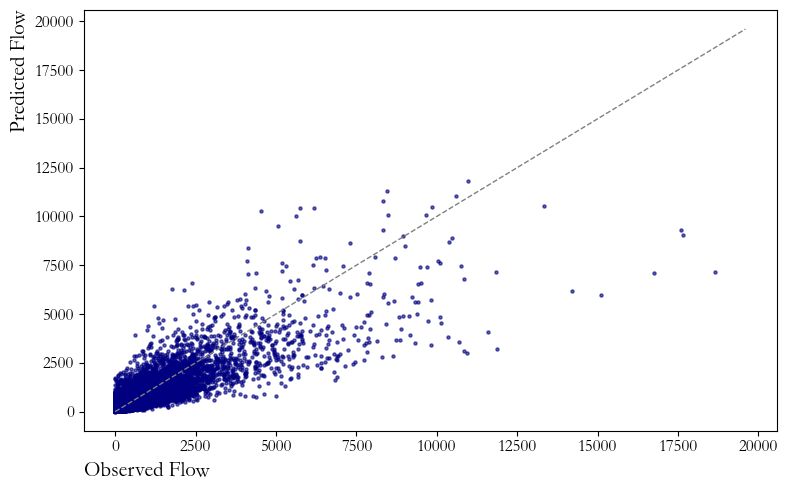

In [ ]:
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Garamond', 'DejaVu Serif', 'Bitstream Vera Serif', 'Computer Modern Roman', 'New Century Schoolbook', 'Century Schoolbook L', 'Utopia', 'ITC Bookman', 'Bookman', 'Nimbus Roman No9 L', 'Times New Roman', 'Times', 'Palatino', 'Charter', 'serif']

# plot the results for all
fig, ax = plt.subplots(1, 1, figsize = (8, 5))

od_matrix_multi_exc.plot.scatter(
    x = 'obs_total_flow',
    y = 'pred_total',
    ax = ax,
    s = 5,
    c = 'navy',
    alpha = 0.6
)

# plot diagonal line
ax.plot(
    [0,max(ax.get_xlim()[1], ax.get_ylim()[1])],
    [0,max(ax.get_xlim()[1], ax.get_ylim()[1])],
    color='gray', linestyle='--',
    linewidth = 1
)

# change the axis
ax.set_xlabel('Observed Flow', fontsize = 15, loc = 'left')
ax.set_ylabel('Predicted Flow', fontsize = 15, loc = 'top')
# ax.set_title('Total Flows')

ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)

plt.tight_layout()
plt.savefig('documents/img/doubly_constrained_flows_total.png', bbox_inches = 'tight')

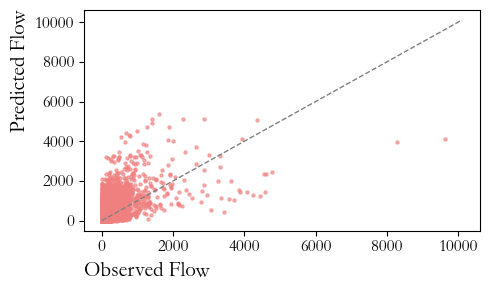

In [ ]:
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Garamond', 'DejaVu Serif', 'Bitstream Vera Serif', 'Computer Modern Roman', 'New Century Schoolbook', 'Century Schoolbook L', 'Utopia', 'ITC Bookman', 'Bookman', 'Nimbus Roman No9 L', 'Times New Roman', 'Times', 'Palatino', 'Charter', 'serif']

# plot the results for all
fig, ax = plt.subplots(1, 1, figsize = (5, 3))

od_matrix_multi_exc.plot.scatter(
    x = 'vehicle',
    y = 'pred_vehicle',
    ax = ax,
    s = 5,
    c = 'lightcoral',
    alpha = 0.6,
    # label = 'Private Vehicles'
)

# plot diagonal line
ax.plot(
    [0,max(ax.get_xlim()[1], ax.get_ylim()[1])],
    [0,max(ax.get_xlim()[1], ax.get_ylim()[1])],
    color='gray', linestyle='--',
    linewidth = 1
)

# change the axis
ax.set_xlabel('Observed Flow', fontsize = 15, loc = 'left')
ax.set_ylabel('Predicted Flow', fontsize = 15, loc = 'top')
# ax.set_title('Vehicles')

ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)

plt.tight_layout()
plt.savefig('documents/img/doubly_constrained_flows_vehicles.png', bbox_inches = 'tight')

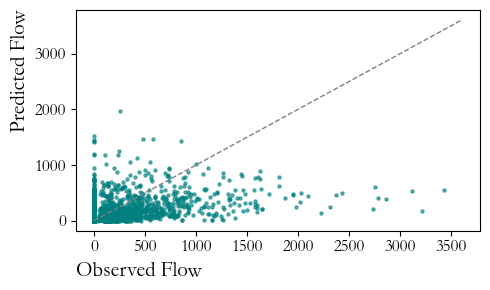

In [ ]:
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Garamond', 'DejaVu Serif', 'Bitstream Vera Serif', 'Computer Modern Roman', 'New Century Schoolbook', 'Century Schoolbook L', 'Utopia', 'ITC Bookman', 'Bookman', 'Nimbus Roman No9 L', 'Times New Roman', 'Times', 'Palatino', 'Charter', 'serif']

# plot the results for all
fig, ax = plt.subplots(1, 1, figsize = (5, 3))

# plot for both public transport and private
od_matrix_multi_exc.plot.scatter(
    x = 'bus',
    y = 'pred_bus',
    ax = ax,
    s = 5,
    c = 'teal',
    alpha = 0.6,
    # label = 'Buses'
)

# plot diagonal line
ax.plot(
    [0,max(ax.get_xlim()[1], ax.get_ylim()[1])],
    [0,max(ax.get_xlim()[1], ax.get_ylim()[1])],
    color='gray', linestyle='--',
    linewidth = 1
)

# change the axis
ax.set_xlabel('Observed Flow', fontsize = 15, loc = 'left')
ax.set_ylabel('Predicted Flow', fontsize = 15, loc = 'top')
# ax.set_title('Buses')

ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)

plt.tight_layout()
plt.savefig('documents/img/doubly_constrained_flows_buses.png', bbox_inches = 'tight')

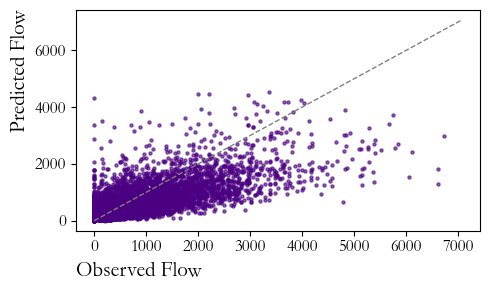

In [ ]:
# plot the results for both
fig, ax = plt.subplots(1, 1, figsize = (5, 3))

# plot for both public transport and private
od_matrix_multi_exc.plot.scatter(
    x = 'rail',
    y = 'pred_rail',
    ax = ax,
    s = 5,
    c = 'indigo',
    alpha = 0.6,
    # label = 'Rail'
)

# plot diagonal line
ax.plot(
    [0,max(ax.get_xlim()[1], ax.get_ylim()[1])],
    [0,max(ax.get_xlim()[1], ax.get_ylim()[1])],
    color='gray', linestyle='--',
    linewidth = 1
)

# change the axis
ax.set_xlabel('Observed Flow', fontsize = 15, loc = 'left')
ax.set_ylabel('Predicted Flow', fontsize = 15, loc = 'top')
# ax.set_title('Rail')

ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)

plt.tight_layout()
plt.savefig('documents/img/doubly_constrained_flows_rail.png', bbox_inches = 'tight')

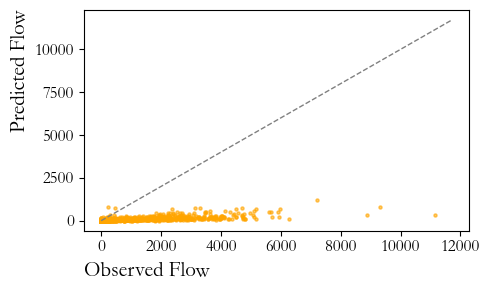

In [ ]:
# plot the results for both
fig, ax = plt.subplots(1, 1, figsize = (5, 3))

# plot for both public transport and private
od_matrix_multi_exc.plot.scatter(
    x = 'pedestrian',
    y = 'pred_walk',
    ax = ax,
    s = 5,
    c = 'orange',
    alpha = 0.6,
    # label = 'Pedestrian'
)

# plot diagonal line
ax.plot(
    [0,max(ax.get_xlim()[1], ax.get_ylim()[1])],
    [0,max(ax.get_xlim()[1], ax.get_ylim()[1])],
    color='gray', linestyle='--',
    linewidth = 1
)

# change the axis
ax.set_xlabel('Observed Flow', fontsize = 15, loc = 'left')
ax.set_ylabel('Predicted Flow', fontsize = 15, loc = 'top')
# ax.set_title('Pedestrians')

ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)

plt.tight_layout()
plt.savefig('documents/img/doubly_constrained_flows_pedestrians.png', bbox_inches = 'tight')